Web scrapping https://www.politifact.com/ to get every statement by state. 

In [1]:

import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd

pagesToGet= 10

states = ["california", "florida", "illinois", "iowa", "missouri", "new-york", "north-carolina",
     "pennsylvania", "texas", "virginia", "west-virginia", "vermont", "wisconsin", "michigan"]

upperframe=[]

for s in states:  
  for page in range(1,pagesToGet+1):
    print('processing page :', page)
    page_num = str(page)
    url = 'https://www.politifact.com/factchecks/list/?page='+page_num+'&category='+s
    print(url)
    
 
    try:
        page=requests.get(url)                           
    
    except Exception as e:                                   
        error_type, error_obj, error_info = sys.exc_info()      
        print ('ERROR FOR LINK:',url)                        
        print (error_type, 'Line:', error_info.tb_lineno)     
        continue                                              
    time.sleep(2)   
    soup=BeautifulSoup(page.text,'html.parser')
    frame=[]
    links=soup.find_all('li',attrs={'class':'o-listicle__item'})
    print(len(links))
    filename="NEWS.csv"
    f=open(filename,"w", encoding = 'utf-8')
    headers="Statement,Link,Date, Source, Label\n"
    f.write(headers)
    
    for j in links:
        Statement = j.find("div",attrs={'class':'m-statement__quote'}).text.strip()
        Link = "https://www.politifact.com"
        Link += j.find("div",attrs={'class':'m-statement__quote'}).find('a')['href'].strip()
        Date = j.find('div',attrs={'class':'m-statement__body'}).find('footer').text[-18:-1].strip()
        Source = j.find('div', attrs={'class':'m-statement__meta'}).find('a').text.strip()
        Label = j.find('div', attrs ={'class':'m-statement__content'}).find('img',attrs={'class':'c-image__original'}).get('alt').strip()
        state = s
        frame.append((Statement,Link,Date,Source,Label, state))
        f.write(Statement.replace(",","^")+","+Link+","+Date.replace(",","^")+","+Source.replace(",","^")+","+Label.replace(",","^")+"\n")
    upperframe.extend(frame)
f.close()
data=pd.DataFrame(upperframe, columns=['Statement','Link','Date','Source','Label', 'State'])


processing page : 1
https://www.politifact.com/factchecks/list/?page=1&category=california
30
processing page : 2
https://www.politifact.com/factchecks/list/?page=2&category=california
30
processing page : 3
https://www.politifact.com/factchecks/list/?page=3&category=california
30
processing page : 4
https://www.politifact.com/factchecks/list/?page=4&category=california
30
processing page : 5
https://www.politifact.com/factchecks/list/?page=5&category=california
30
processing page : 6
https://www.politifact.com/factchecks/list/?page=6&category=california
30
processing page : 7
https://www.politifact.com/factchecks/list/?page=7&category=california
30
processing page : 8
https://www.politifact.com/factchecks/list/?page=8&category=california
30
processing page : 9
https://www.politifact.com/factchecks/list/?page=9&category=california
30
processing page : 10
https://www.politifact.com/factchecks/list/?page=10&category=california
30
processing page : 1
https://www.politifact.com/factchecks/

In [2]:

df = data.copy()
df.to_csv('data_politifact.csv')


In [3]:
df = pd.read_csv ('data_politifact.csv')

df['Year'] = df['Date'].str[-4:]

df['Year'].value_counts()

df.head()


,Unnamed: 0,Statement,Link,Date,Source,Label,State,Year
0,0,“California voters to be able to download ball...,https://www.politifact.com/factchecks/2021/aug...,"• August 27, 2021",Larry Elder,barely-true,california,2021
1,1,“CA inmate pregnant after being forced to shar...,https://www.politifact.com/factchecks/2021/aug...,"• August 18, 2021",Viral image,false,california,2021
2,2,“Due to the new ‘delta variant’ California wil...,https://www.politifact.com/factchecks/2021/aug...,"• August 6, 2021",Viral image,false,california,2021
3,3,"“Ambassador Susan Rice Tribunal, Gavin Newsom ...",https://www.politifact.com/factchecks/2021/jul...,"r • July 26, 2021",Facebook posts,pants-fire,california,2021
4,4,“California has a personal belief exemption to...,https://www.politifact.com/factchecks/2021/jul...,"a • July 23, 2021",Instagram posts,false,california,2021


Data cleaning


In [4]:
import numpy as np

lab_to_remove = ['full-flop', 'half-flip', 'no-flip']

df.loc[(df['Label'].isin(lab_to_remove))] = np.nan

df['Label'].value_counts()

false          689
barely-true    538
mostly-true    503
half-true      474
true           364
pants-fire     244
Name: Label, dtype: int64

Creation of the fake news binary variable

In [5]:
vrai = ['true', 'mostly-true', 'half-true']
faux = ['barely-true', 'false', 'pants-fire']

df['fake'] = ''

for i in range(len(df)):
    if df['Label'][i] in vrai:
      df['fake'][i] = 0
    elif df['Label'][i] in faux:
      df['fake'][i] = 1
    else:
      df['fake'][i] = None

df['fake'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


1    1471
0    1341
Name: fake, dtype: int64

Date time variables creation


In [6]:
month = []

for x in df['Date']:
  m = ""
  for char in str(x):
    if char.isalpha():
      m += char
  month.append(m)

df['Month'] = month


In [7]:
m = ["January", "February", "March", "April", "May", "June", "July", "August","September", "October", "November", "December"] 

month = []

for i in df['Month']:
  z = ""
  for j in range(11):
    if m[j] in str(i):
      z = m[j]
      break
    else:
      z = i
  month.append(z)

df['mois'] = month

df["mois"].replace({"eptember": "September", "ptember": "September", "ovember": "November"}, inplace=True)

In [8]:
m = ["January", "February", "March", "April", "May", "June", "July", "August","September", "October", "November", "December"] 

month = []

for i in df['mois']:
  z = ""
  for j in range(len(m)):
    if m[j] == str(i):
      z = j+1
      break
    else:
      z = None
  month.append(z)

df['mois_num'] = month

df['mois_num'].value_counts()

10.0    310
3.0     288
4.0     259
8.0     250
5.0     245
9.0     244
11.0    244
2.0     234
7.0     212
6.0     195
12.0    169
1.0     160
Name: mois_num, dtype: int64

In [9]:
day = []

for i in range(len(df)):
  day.append(1)

df_date = pd.DataFrame({'year': df['Year'],
                        'month': df['mois_num'],
                        'day': day}) 

df['date_num'] = pd.to_datetime(df_date)

In [10]:
# date to quarter

df['quarter'] = df['date_num'].dt.to_period('Q')

df['quarter'].value_counts().sort_index()

2014Q3      8
2014Q4     21
2015Q1     19
2015Q2     16
2015Q3     24
2015Q4     38
2016Q1     50
2016Q2     82
2016Q3    106
2016Q4    102
2017Q1     97
2017Q2     96
2017Q3     94
2017Q4     98
2018Q1    108
2018Q2     99
2018Q3    115
2018Q4    149
2019Q1    121
2019Q2    117
2019Q3     72
2019Q4     98
2020Q1    130
2020Q2    179
2020Q3    209
2020Q4    217
2021Q1    157
2021Q2    110
2021Q3     78
Freq: Q-DEC, Name: quarter, dtype: int64

In [11]:
df.head(10)

,Unnamed: 0,Statement,Link,Date,Source,Label,State,Year,fake,Month,mois,mois_num,date_num,quarter
0,0.0,“California voters to be able to download ball...,https://www.politifact.com/factchecks/2021/aug...,"• August 27, 2021",Larry Elder,barely-true,california,2021,1,August,August,8.0,2021-08-01,2021Q3
1,1.0,“CA inmate pregnant after being forced to shar...,https://www.politifact.com/factchecks/2021/aug...,"• August 18, 2021",Viral image,false,california,2021,1,August,August,8.0,2021-08-01,2021Q3
2,2.0,“Due to the new ‘delta variant’ California wil...,https://www.politifact.com/factchecks/2021/aug...,"• August 6, 2021",Viral image,false,california,2021,1,August,August,8.0,2021-08-01,2021Q3
3,3.0,"“Ambassador Susan Rice Tribunal, Gavin Newsom ...",https://www.politifact.com/factchecks/2021/jul...,"r • July 26, 2021",Facebook posts,pants-fire,california,2021,1,rJuly,July,7.0,2021-07-01,2021Q3
4,4.0,“California has a personal belief exemption to...,https://www.politifact.com/factchecks/2021/jul...,"a • July 23, 2021",Instagram posts,false,california,2021,1,aJuly,July,7.0,2021-07-01,2021Q3
5,5.0,“Newly obtained emails show UCSF harvesting th...,https://www.politifact.com/factchecks/2021/jul...,"a • July 16, 2021",Facebook posts,false,california,2021,1,aJuly,July,7.0,2021-07-01,2021Q3
6,6.0,"Says in February Facebook post that ""Britney w...",https://www.politifact.com/factchecks/2021/jul...,"r • July 14, 2021",Facebook posts,barely-true,california,2021,1,rJuly,July,7.0,2021-07-01,2021Q3
7,7.0,“San Francisco Allowing Children to ‘Consent’ ...,https://www.politifact.com/factchecks/2021/jul...,"ón • July 8, 2021",Facebook posts,barely-true,california,2021,1,ónJuly,July,7.0,2021-07-01,2021Q3
8,8.0,“California literally just told everyone to no...,https://www.politifact.com/factchecks/2021/jul...,"ka • July 2, 2021",Facebook posts,false,california,2021,1,kaJuly,July,7.0,2021-07-01,2021Q3
9,9.0,“Maxine Waters just introduced a bill to re-na...,https://www.politifact.com/factchecks/2021/jun...,"l • June 25, 2021",Facebook posts,pants-fire,california,2021,1,lJune,June,6.0,2021-06-01,2021Q2


**Graphique 1: nombre de déclaration par trimestre** 




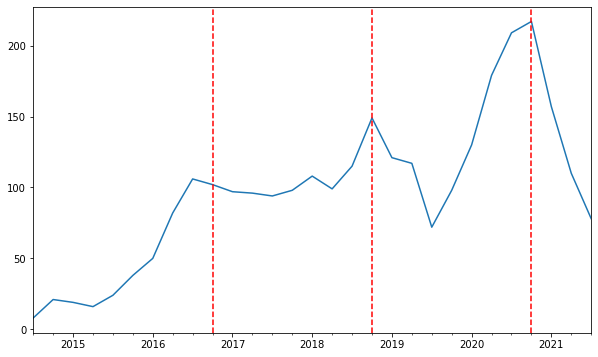

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fig.set_size_inches(10, 6)

ax = df['quarter'].value_counts().sort_index().plot(ax=ax, kind='line')

ax.axvline("2020Q4", color="red", linestyle="--")

ax.axvline("2016Q4", color="red", linestyle="--")

ax.axvline("2018Q4", color="red", linestyle="--")


**Graphique 2: proportion de fausses nouvelles par trimestre**

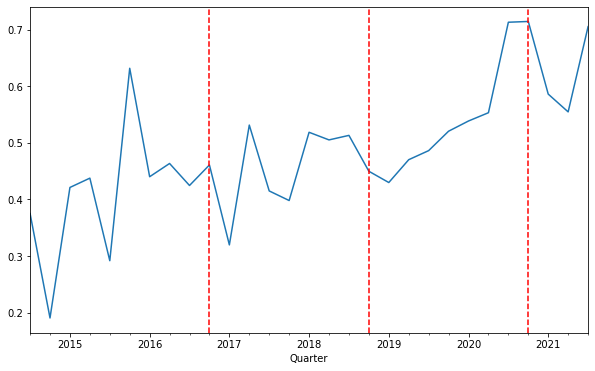

In [13]:
df['fake'] = pd.to_numeric(df['fake'])

Mean = df.groupby('quarter')['fake'].mean()
Std = df.groupby('quarter')['fake'].std()

ts_fake = pd.DataFrame({'Quarter': Mean.index ,'fake_news': Mean})

g2 = ts_fake.plot('Quarter', 'fake_news', figsize = (10,6), legend = False)

g2.axvline("2020Q4", color="red", linestyle="--")

g2.axvline("2016Q4", color="red", linestyle="--")

g2.axvline("2018Q4", color="red", linestyle="--")


Binary variable of election

In [14]:
dft = df.copy()

sub_data = dft.loc[dft['quarter'] == '2018Q4']

sub_data['mois_num'].value_counts()


10.0    83
11.0    39
12.0    27
Name: mois_num, dtype: int64

In [15]:
import datetime as dt

# variable indicating the semester

df['quarter_num'] = df['quarter'].astype(str)

df['quarter_num'] = pd.to_datetime(df['quarter_num'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')

df['quarter_num'] = df['quarter_num'].map(dt.datetime.toordinal)

df.loc[df['quarter_num'] == 1] = None

quarter_list = df['quarter_num'].sort_values().unique().tolist()

quarter_list = quarter_list[:-1]

quarter_list

# replacing values by simple numbers

df['quarter_number'] = ''

for i in range(len(df)):
  for j in range(len(quarter_list)):
    if df['quarter_num'][i] == quarter_list[j]:
      df['quarter_number'][i] = j+1
      break
    else:
      df['quarter_number'][i] = None

df['quarter_number'].value_counts().sort_index()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1       8
2      21
3      19
4      16
5      24
6      38
7      50
8      82
9     106
10    102
11     97
12     96
13     94
14     98
15    108
16     99
17    115
18    149
19    121
20    117
21     72
22     98
23    130
24    179
25    209
26    217
27    157
28    110
29     78
Name: quarter_number, dtype: int64

In [16]:
list_elec = list(range(9,11)) +list(range(25,27))

list_elec

[9, 10, 25, 26]

In [17]:

df['election'] = ''

list_elec_year = ['2016', '2020']

list_elec_month = list(range(6,12))

for i in range(len(df)):
  if (df['mois_num'][i] in list_elec_month and df['Year'][i] in list_elec_year):
    df['election'][i] = 1
  else:
    df['election'][i] = 0

df['election'].value_counts().sort_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


0    2208
1     640
Name: election, dtype: int64

Season variable

In [18]:
df['Saison'] = ''

list_automne = [10,11,12]
list_hiver = [1,2,3]
list_printemps = [4,5,6]
list_été = [7,8,9]

for i in range(len(df)):
  if df['mois_num'][i] in list_automne:
    df['Saison'][i] = 'automne'
  elif df['mois_num'][i] in list_hiver:
    df['Saison'][i] = 'hiver'
  elif df['mois_num'][i] in list_printemps:
    df['Saison'][i] = 'printemps'
  elif df['mois_num'][i] in list_été:
    df['Saison'][i] = 'été'
  else:
    df['Saison'][i] = None

df['Saison'].value_counts().sort_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher

automne      723
hiver        682
printemps    699
été          706
Name: Saison, dtype: int64

Model 1 


In [19]:
pip install stargazer

In [20]:

import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer, LineLocation

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Descriptive Statistics**

In [21]:
tab1 = pd.concat([df['fake'].value_counts(),df['fake'].value_counts(normalize = True).round(2).mul(100)],axis =1 , keys = ['Fréquence', 'Pourcentage'])
tab1

,Fréquence,Pourcentage
1.0,1471,52.0
0.0,1339,48.0


In [22]:
tab2 = pd.concat([df['Source'].value_counts().head(10), df['Source'].value_counts(normalize = True).mul(100).head(10).round(2)],
                 axis = 1, keys = ['Fréquence', 'Pourcentage'])

tab2

,Fréquence,Pourcentage
Facebook posts,202,7.19
Donald Trump,137,4.88
Viral image,58,2.06
Andrew Cuomo,38,1.35
Ted Cruz,35,1.25
Greg Abbott,27,0.96
Kamala Harris,26,0.93
Bloggers,26,0.93
Rick Scott,25,0.89
Bernie Sanders,24,0.85


In [23]:
tab3 = pd.concat([df['State'].value_counts(), df['State'].value_counts(normalize = True).mul(100).round(2)],
                 axis = 1, keys = ['Fréquence', 'Pourcentage'])

tab3

,Fréquence,Pourcentage
california,299,10.64
florida,298,10.60
texas,297,10.57
wisconsin,291,10.36
north-carolina,289,10.28
virginia,288,10.25
new-york,246,8.75
illinois,195,6.94
missouri,192,6.83
pennsylvania,163,5.80


**Text Analysis**

In [24]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from collections import defaultdict

tokenizer = RegexpTokenizer(r'\w+')

ignore = set(stopwords.words('english'))

#add words that aren't in the NLTK stopwords list

new_stopwords = ['say', 'vote', 'year', 'state', 'people']

ignore = ignore.union(new_stopwords)

##

data = df['Statement'].astype(str).tolist()

data_token = [tokenizer.tokenize(w.lower()) for w in data]

for l in range(len(data_token)):
  data_token[l] = list(set(data_token[l])-ignore)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [25]:
dat=[]

# dictionnaire

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# à chaque mot s'il ne tombe pas dans les catégorie il nous redonne un nom.

for index, entry in enumerate(data_token):
  Final_words = []
  word_Lemmatized = WordNetLemmatizer()
  for word, tag in pos_tag(entry): # tage indique le type de mots
    if word.isalpha():
      word_final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
      Final_words.append(word_final)
  dat.append(Final_words)

data_join = [' '.join(l) for l in list(dat)]

**Word cloud**

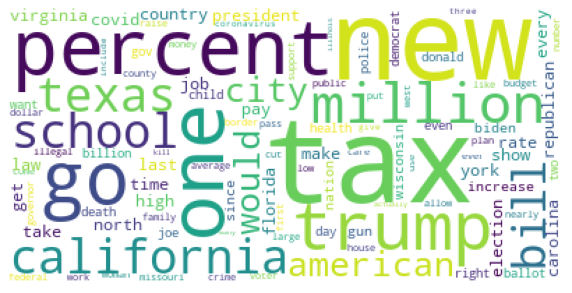

<Figure size 432x288 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

words = ' '.join(data_join)

wordcloud = WordCloud(max_words=100, collocations=False, background_color='white', stopwords = ignore).generate(words)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

plt.savefig('g3_fn.png', dpi=100)

**TF-IDF**

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

vectorizer = CountVectorizer(ngram_range = (1,1), min_df= 5, max_df= 0.6, stop_words='english')
X = vectorizer.fit_transform(data_join)

X.shape

vocab = vectorizer.get_feature_names()

for i, comp in enumerate(lda.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
say vote trump virginia election law president biden republican california 

Topic 1: 
tax say new state million percent school year american job 



Latent Dirchlet allocation with 2 themes

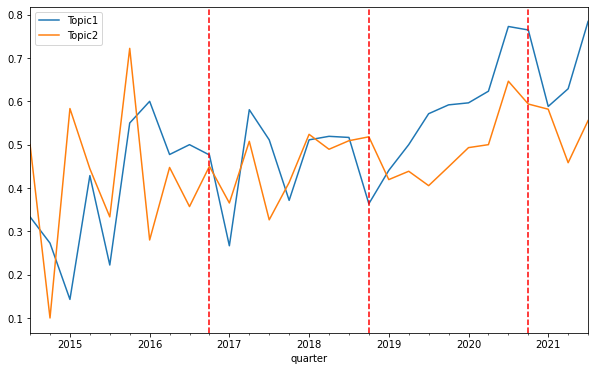

In [35]:
lda = LatentDirichletAllocation(n_components=2)

model = lda.fit(X)

lda_output = model.transform(X)

topicnames = ["Topic" + str(i) for i in range(1,3)]

topic_share = pd.DataFrame(np.round(lda_output, 2), columns=topicnames)

df_ts_share =  pd.concat([df[['quarter', 'fake']], topic_share], axis=1)

dominant_topic = np.argmax(topic_share.values, axis=1)

df_ts_share['dominant_topic'] = dominant_topic

df1 = df_ts_share.loc[df_ts_share['dominant_topic'] == 0]
df2 = df_ts_share.loc[df_ts_share['dominant_topic'] == 1]

Mean1 = df1.groupby('quarter')['fake'].mean()
Mean2 = df2.groupby('quarter')['fake'].mean()

tab = pd.DataFrame({'Quarter': Mean1.index ,'Topic1': Mean1,'Topic2': Mean2})

ax = tab.plot.line(figsize = (10,6))

ax.axvline("2020Q4", color="red", linestyle="--")

ax.axvline("2016Q4", color="red", linestyle="--")

ax.axvline("2018Q4", color="red", linestyle="--")


In [36]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1] 
feature_names = np.array(vectorizer.get_feature_names())

for index, topic in enumerate(lda.components_):
    print(f'Topic #{index+1}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-50:]])
    print('\n')

Topic #1
['pennsylvania', 'united', 'america', 'large', 'teacher', 'michigan', 'time', 'number', 'billion', 'use', 'world', 'education', 'national', 'new', 'month', 'support', 'make', 'illegal', 'gov', 'kill', 'california', 'west', 'democrat', 'house', 'gun', 'percent', 'million', 'wisconsin', 'governor', 'border', 'voter', 'come', 'florida', 'right', 'day', 'law', 'joe', 'ballot', 'biden', 'republican', 'election', 'carolina', 'year', 'texas', 'north', 'vote', 'school', 'virginia', 'state', 'say']


Topic #2
['like', 'child', 'florida', 'unemployment', 'year', 'allow', 'public', 'money', 'income', 'obama', 'billion', 'case', 'want', 'average', 'fund', 'vote', 'crime', 'health', 'nation', 'woman', 'care', 'work', 'family', 'make', 'raise', 'cut', 'low', 'missouri', 'donald', 'police', 'death', 'covid', 'time', 'york', 'job', 'pay', 'california', 'increase', 'million', 'president', 'country', 'high', 'rate', 'city', 'percent', 'american', 'new', 'trump', 'tax', 'say']




In [37]:
def draw_word_cloud(index):
  imp_words_topic=""
  comp=lda.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400, background_color = 'white', stopwords = ignore).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

Theme 1

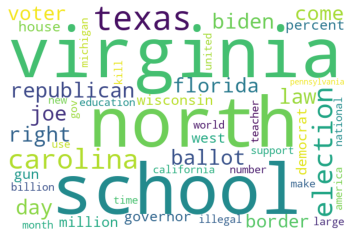

In [38]:
draw_word_cloud(0)

Theme 2

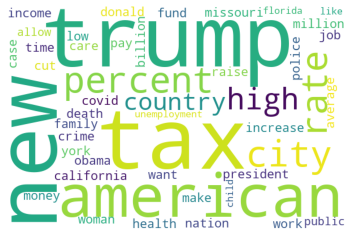

In [39]:
draw_word_cloud(1)

In [40]:
tab

,Quarter,Topic1,Topic2
quarter,,,
2014Q3,2014Q3,0.333333,0.500000
2014Q4,2014Q4,0.272727,0.100000
2015Q1,2015Q1,0.142857,0.583333
2015Q2,2015Q2,0.428571,0.444444
2015Q3,2015Q3,0.222222,0.333333
2015Q4,2015Q4,0.550000,0.722222
2016Q1,2016Q1,0.600000,0.280000
2016Q2,2016Q2,0.477273,0.447368
2016Q3,2016Q3,0.500000,0.357143


In [41]:
tab = tab.iloc[9:]


In [42]:
tab['quarter_num'] = tab['Quarter'].astype(str)

tab['quarter_num'] = pd.to_datetime(tab['quarter_num'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')

tab['quarter_num'] = tab['quarter_num'].map(dt.datetime.toordinal)

tab


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

,Quarter,Topic1,Topic2,quarter_num
quarter,,,,
2016Q4,2016Q4,0.476190,0.450000,736238
2017Q1,2017Q1,0.266667,0.365385,736330
2017Q2,2017Q2,0.580645,0.507692,736420
2017Q3,2017Q3,0.511111,0.326531,736511
2017Q4,2017Q4,0.371429,0.412698,736603
2018Q1,2018Q1,0.511111,0.523810,736695
2018Q2,2018Q2,0.519231,0.489362,736785
2018Q3,2018Q3,0.516667,0.509091,736876
2018Q4,2018Q4,0.363636,0.518072,736968


Regression model 1

In [43]:
f1 = 'Topic1 ~ Topic2'
f2 = 'Topic1 ~ Topic2 + quarter_num'

m1 = smf.ols(formula = f1, data = tab)
m2 = smf.ols(formula = f2, data = tab)

m1 = m1.fit()
m2 = m2.fit()

stargazer = Stargazer([m1, m2])

stargazer.significant_digits(4) 

stargazer.covariate_order(['Topic2', 'quarter_num'])

stargazer.rename_covariates({'Topic2':'Thème 2' ,'quarter_num': 'Temps'})

stargazer

Regression model 2

In [45]:
df =  pd.concat([df, topic_share], axis=1)

formula_1 = 'fake ~ quarter_num + election'
formula_2 = 'fake ~ quarter_num + election'
formula_3 = 'fake ~ quarter_num + election + Saison'
formula_4 = 'fake ~ quarter_num + election + Saison + State'
formula_5 = 'fake ~ quarter_num + election + Saison + State + Topic1 + Topic2'

model1 = smf.ols(formula = formula_1, data = df)

df['election'] = ''

list_elec_year = ['2016', '2018', '2020']

list_elec_month = list(range(6,12))

for i in range(len(df)):
  if (df['mois_num'][i] in list_elec_month and df['Year'][i] in list_elec_year):
    df['election'][i] = 1
  else:
    df['election'][i] = 0

model2 = smf.ols(formula = formula_2, data = df)
model3 = smf.ols(formula = formula_3, data = df)
model4 = smf.ols(formula = formula_4, data = df)
model5 = smf.ols(formula = formula_5, data = df)

r1 = model1.fit()
r2 = model2.fit()
r3 = model3.fit()
r4 = model4.fit()
r5 = model5.fit()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
stargazer = Stargazer([r1, r2, r3, r4, r5])

stargazer.significant_digits(4) 

stargazer.covariate_order(['election[T.1]', 'quarter_num', 'Topic1', 'Topic2'])

stargazer.rename_covariates({'quarter_num': 'Trimestre', 'election[T.1]': 'Élection'})

stargazer.add_line('Élection chambre', ['Non', 'Oui', 'Oui', 'Oui', 'Oui'])
stargazer.add_line('Saison', ['Non', 'Non', 'Oui', 'Oui', 'Oui'])
stargazer.add_line('État', ['Non', 'Non', 'Non', 'Oui', 'Oui'])

stargazer
